In [ ]:
"""
3D-FRONT Scene Isometric Visualizer for Jupyter Notebook
Visualize scenes with textured and semantic views side-by-side
"""

import json
import sys
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# Add parent directory to path to import utils
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

from data_preperation.utils.semantic_utils import Taxonomy


# =============================================================================
# Configuration
# =============================================================================

class VisualizationConfig:
    """Configuration for scene visualization"""
    def __init__(self):
        self.max_points = 50000
        self.point_size = 1.0
        self.figsize = (16, 8)
        self.dpi = 150
        self.elev = 30
        self.azim = 225
        self.format = "parquet"
        
    def update(self, **kwargs):
        """Update configuration with keyword arguments"""
        for key, value in kwargs.items():
            if hasattr(self, key):
                setattr(self, key, value)
        return self


# =============================================================================
# Core Functions
# =============================================================================

def load_point_cloud(scene_dir: Path, scene_id: str, format: str = "parquet") -> pd.DataFrame:
    """Load point cloud from parquet or csv."""
    if format == "parquet":
        file_path = scene_dir / f"{scene_id}_sem_pointcloud.parquet"
        return pd.read_parquet(file_path)
    else:
        file_path = scene_dir / f"{scene_id}_sem_pointcloud.csv"
        return pd.read_csv(file_path)


def load_scene_info(scene_dir: Path, scene_id: str) -> Dict:
    """Load scene metadata."""
    scene_info_path = scene_dir / f"{scene_id}_scene_info.json"
    with open(scene_info_path, 'r') as f:
        return json.load(f)


def create_category_colormap(taxonomy: Taxonomy, categories: List[str]) -> Dict[str, np.ndarray]:
    """Create a consistent color mapping for categories using taxonomy colors."""
    unique_cats = sorted(set(categories))
    
    color_map = {}
    for cat in unique_cats:
        # Try to get color from taxonomy
        try:
            # Get the category ID first
            cat_id = taxonomy.translate(cat, output="id")
            if cat_id is not None:
                # Get color from taxonomy (assumes it returns RGB tuple or hex)
                tax_color = taxonomy.get_color(cat_id)
                if tax_color is not None:
                    # Convert to numpy array if needed
                    if isinstance(tax_color, str):
                        # Hex color
                        tax_color = tax_color.lstrip('#')
                        color_map[cat] = np.array([int(tax_color[i:i+2], 16) for i in (0, 2, 4)]) / 255.0
                    else:
                        # Assume RGB tuple (0-255 or 0-1)
                        rgb = np.array(tax_color)
                        if rgb.max() > 1.0:
                            rgb = rgb / 255.0
                        color_map[cat] = rgb[:3]  # RGB only, no alpha
                    continue
        except (AttributeError, KeyError, TypeError):
            pass
        
        # Fallback: use colormap for categories not in taxonomy
        idx = list(unique_cats).index(cat)
        base_colors = plt.cm.tab20c(np.linspace(0, 1, 20))
        extended_colors = plt.cm.Set3(np.linspace(0, 1, 12))
        all_colors = np.vstack([base_colors, extended_colors])
        color_map[cat] = all_colors[idx % len(all_colors)][:3]
    
    # Override for architectural elements if not in taxonomy
    if 'floor' in color_map and 'floor' not in [c for c in unique_cats if taxonomy.translate(c, output="id") is not None]:
        color_map['floor'] = np.array([0.8, 0.8, 0.8])
    if 'wall' in color_map and 'wall' not in [c for c in unique_cats if taxonomy.translate(c, output="id") is not None]:
        color_map['wall'] = np.array([0.9, 0.9, 0.85])
    
    return color_map


def downsample_points(df: pd.DataFrame, max_points: int) -> pd.DataFrame:
    """Downsample point cloud for faster rendering."""
    if len(df) <= max_points:
        return df
    
    indices = np.random.choice(len(df), max_points, replace=False)
    return df.iloc[indices]


def setup_isometric_view(ax: Axes3D, bounds: Dict, elev: float = 30, azim: float = 225):
    """Configure axis for isometric view."""
    # Since we rotated the scene data (swapped Y and Z), adjust bounds accordingly
    x_range = bounds['max'][0] - bounds['min'][0]
    y_range = bounds['max'][2] - bounds['min'][2]  # data Z -> plot Y
    z_range = bounds['max'][1] - bounds['min'][1]  # data Y -> plot Z
    
    max_range = max(x_range, y_range, z_range)
    mid_x = (bounds['max'][0] + bounds['min'][0]) / 2
    mid_y = (bounds['max'][2] + bounds['min'][2]) / 2  # data Z
    mid_z = (bounds['max'][1] + bounds['min'][1]) / 2  # data Y
    
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)
    
    # Isometric viewing angle
    ax.view_init(elev=elev, azim=azim)
    
    # Plot axes are standard: X, Y, Z with Z pointing up
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z (Up)')
    ax.grid(True, alpha=0.3)
    


def plot_textured_view(ax: Axes3D, df: pd.DataFrame, bounds: Dict, 
                       point_size: float = 1.0, elev: float = 30, azim: float = 225):
    """Plot textured (RGB) view."""
    # Normalize RGB values
    colors = np.column_stack([df['r'], df['g'], df['b']]) / 255.0
    
    # Rotate the scene: swap Y and Z in the DATA to fix orientation
    # Original data has Z up, but scene is oriented wrong
    # New mapping: data_x -> plot_x, data_z -> plot_y, data_y -> plot_z
    ax.scatter(df['x'], df['z'], df['y'], 
               c=colors, 
               s=point_size, 
               alpha=0.8,
               edgecolors='none')
    
    setup_isometric_view(ax, bounds, elev, azim)
    ax.set_title('Textured View', fontsize=14, fontweight='bold')


def plot_semantic_view(ax: Axes3D, df: pd.DataFrame, bounds: Dict, 
                       taxonomy: Taxonomy, point_size: float = 1.0, 
                       elev: float = 30, azim: float = 225, show_legend: bool = True):
    """Plot semantic (category-colored) view."""
    # Create color mapping
    color_map = create_category_colormap(taxonomy, df['category'].tolist())
    
    # Assign colors to each point
    colors = np.array([color_map[cat] for cat in df['category']])
    
    # Rotate the scene: swap Y and Z in the DATA to fix orientation
    # Original data has Z up, but scene is oriented wrong
    # New mapping: data_x -> plot_x, data_z -> plot_y, data_y -> plot_z
    ax.scatter(df['x'], df['z'], df['y'], 
               c=colors, 
               s=point_size, 
               alpha=0.8,
               edgecolors='none')
    
    setup_isometric_view(ax, bounds, elev, azim)
    ax.set_title('Semantic View', fontsize=14, fontweight='bold')
    
    # Add legend for top categories
    if show_legend:
        unique_cats = df['category'].value_counts().head(10).index.tolist()
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                       markerfacecolor=color_map[cat], 
                                       markersize=8, label=cat)
                           for cat in unique_cats if cat in color_map]
        
        ax.legend(handles=legend_elements, loc='upper left', 
                  bbox_to_anchor=(1.05, 1), fontsize=8)


# =============================================================================
# Main Visualization Function
# =============================================================================

def visualize_scene(scene_dir: Path, 
                   scene_id: str, 
                   taxonomy: Taxonomy,
                   config: Optional[VisualizationConfig] = None,
                   output_path: Optional[Path] = None,
                   show_legend: bool = True) -> plt.Figure:
    """
    Create side-by-side isometric visualization.
    
    Parameters
    ----------
    scene_dir : Path
        Directory containing scene point clouds and metadata
    scene_id : str
        Scene ID to visualize
    taxonomy : Taxonomy
        Taxonomy object for semantic mapping
    config : VisualizationConfig, optional
        Configuration object with visualization parameters
    output_path : Path, optional
        If provided, save figure to this path
    show_legend : bool, default=True
        Whether to show the category legend
        
    Returns
    -------
    fig : matplotlib.figure.Figure
        The created figure
    """
    if config is None:
        config = VisualizationConfig()
    
    # Load data
    print(f"Loading scene {scene_id}...")
    df = load_point_cloud(scene_dir, scene_id, config.format)
    scene_info = load_scene_info(scene_dir, scene_id)
    
    # Downsample if needed
    if len(df) > config.max_points:
        print(f"Downsampling from {len(df)} to {config.max_points} points...")
        df = downsample_points(df, config.max_points)
    
    # Create figure with two subplots
    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    
    # Textured view (left)
    ax1 = fig.add_subplot(121, projection='3d')
    plot_textured_view(ax1, df, scene_info['bounds'], 
                      config.point_size, config.elev, config.azim)
    
    # Semantic view (right)
    ax2 = fig.add_subplot(122, projection='3d')
    plot_semantic_view(ax2, df, scene_info['bounds'], taxonomy, 
                      config.point_size, config.elev, config.azim, show_legend)
    
    # Add main title
    fig.suptitle(f'Scene: {scene_id}', fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    
    # Save if output path provided
    if output_path:
        output_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(output_path, bbox_inches='tight', dpi=config.dpi)
        print(f"Saved visualization to {output_path}")
    
    return fig


# =============================================================================
# Convenience Functions
# =============================================================================

def quick_viz(scene_dir: str, scene_id: str, taxonomy_path: str, **kwargs):
    """Quick visualization with string paths."""
    taxonomy = Taxonomy(Path(taxonomy_path))
    config = VisualizationConfig()
    config.update(**kwargs)
    
    return visualize_scene(
        Path(scene_dir), 
        scene_id, 
        taxonomy, 
        config
    )


def batch_visualize(scene_dir: Path, 
                   scene_ids: List[str], 
                   taxonomy: Taxonomy,
                   output_dir: Optional[Path] = None,
                   config: Optional[VisualizationConfig] = None):
    """Visualize multiple scenes."""
    if config is None:
        config = VisualizationConfig()
    
    if output_dir:
        output_dir.mkdir(parents=True, exist_ok=True)
    
    for scene_id in scene_ids:
        print(f"\n{'='*60}")
        print(f"Processing: {scene_id}")
        print('='*60)
        
        try:
            output_path = output_dir / f"{scene_id}_viz.png" if output_dir else None
            fig = visualize_scene(scene_dir, scene_id, taxonomy, config, output_path)
            
            if not output_path:
                plt.show()
            plt.close(fig)
            
        except Exception as e:
            print(f"Error processing {scene_id}: {e}")


def print_scene_stats(scene_dir: Path, scene_id: str, format: str = "parquet"):
    """Print statistics about a scene."""
    df = load_point_cloud(scene_dir, scene_id, format)
    
    print(f"Scene: {scene_id}")
    print(f"Total points: {len(df):,}")
    print(f"\nTop 15 Categories:")
    print(df['category'].value_counts().head(15))
    print(f"\nRoom types:")
    print(df['room_type'].value_counts())
    print(f"\nBounds:")
    print(f"  X: [{df['x'].min():.2f}, {df['x'].max():.2f}]")
    print(f"  Y: [{df['y'].min():.2f}, {df['y'].max():.2f}]")
    print(f"  Z: [{df['z'].min():.2f}, {df['z'].max():.2f}]")
    
    return df


print("✓ Visualization functions loaded successfully!")
print("\nQuick start examples:")
print("  1. print_scene_stats(scene_dir, scene_id)")
print("  2. config = VisualizationConfig()")
print("  3. fig = visualize_scene(scene_dir, scene_id, taxonomy, config)")

In [ ]:

scene_dir = Path(r"C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\repositories\ImagiNav\dataset\00ecd5d3-d369-459f-8300-38fc159823dc")
scene_id = "00ecd5d3-d369-459f-8300-38fc159823dc"
taxonomy_path = Path(r"C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\repositories\ImagiNav\config\taxonomy.json")

taxonomy = Taxonomy(taxonomy_path)


In [ ]:

# Cell 2: Quick stats
print_scene_stats(scene_dir, scene_id)


In [ ]:

# Cell 3: Default visualization
config = VisualizationConfig()
fig = visualize_scene(scene_dir, scene_id, taxonomy, config)
plt.show()


In [ ]:

# Cell 4: Custom view
config = VisualizationConfig()
config.update(
    elev=30,
    azim=50,
    max_points=100000,
    point_size=10,
    figsize=(20, 10)
)
fig = visualize_scene(scene_dir, scene_id, taxonomy, config)
plt.show()


In [26]:
"""
Scene + Rooms Grid Visualization
Shows entire scene on left, and grid of room views on right
"""

import json
from pathlib import Path
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


def load_room_point_cloud(room_dir: Path, scene_id: str, room_id: str) -> pd.DataFrame:
    """Load room point cloud from parquet."""
    file_path = room_dir / f"{scene_id}_{room_id}.parquet"
    return pd.read_parquet(file_path)


def load_room_layout_image(room_dir: Path, scene_id: str, room_id: str, 
                           layout_type: str = "room_seg_layout") -> Optional[np.ndarray]:
    """Load room layout image. layout_type can be 'graph_vis' or 'room_seg_layout'."""
    image_path = room_dir / "layouts" / f"{scene_id}_{room_id}_{layout_type}.png"
    if image_path.exists():
        return mpimg.imread(image_path)
    return None


def get_available_rooms(scene_dir: Path) -> List[str]:
    """Get list of available room IDs that have point cloud data."""
    rooms_dir = scene_dir / "rooms"
    room_ids = []
    
    for room_path in sorted(rooms_dir.iterdir()):
        if room_path.is_dir():
            # Check if room has .parquet file
            parquet_files = list(room_path.glob("*.parquet"))
            if parquet_files:
                room_ids.append(room_path.name)
    
    return room_ids


def plot_small_3d_pointcloud(ax: Axes3D, df: pd.DataFrame, color_data: np.ndarray,
                            title: str = "", point_size: float = 0.5, 
                            elev: float = 20, azim: float = 45):
    """Plot a small 3D point cloud view."""
    # Rotate: data_x -> plot_x, data_z -> plot_y, data_y -> plot_z
    ax.scatter(df['x'], df['z'], df['y'], 
               c=color_data, 
               s=point_size, 
               alpha=0.8,
               edgecolors='none')
    
    # Use provided viewing angles
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(title, fontsize=8)
    
    # Add buffer around data (10% on each side)
    x_range = df['x'].max() - df['x'].min()
    y_range = df['z'].max() - df['z'].min()
    z_range = df['y'].max() - df['y'].min()
    
    buffer = 0.1
    ax.set_xlim(df['x'].min() - buffer * x_range, df['x'].max() + buffer * x_range)
    ax.set_ylim(df['z'].min() - buffer * y_range, df['z'].max() + buffer * y_range)
    ax.set_zlim(df['y'].min() - buffer * z_range, df['y'].max() + buffer * z_range)
    
    # Minimal labels
    ax.set_xlabel('X', fontsize=6)
    ax.set_ylabel('Y', fontsize=6)
    ax.set_zlabel('Z', fontsize=6)
    ax.tick_params(labelsize=5)
    ax.grid(True, alpha=0.2)


def visualize_scene_with_rooms(scene_dir: Path, 
                               scene_id: str, 
                               taxonomy,
                               max_points_scene: int = 50000,
                               max_points_room: int = 10000,
                               point_size_scene: float = 1.0,
                               point_size_room: float = 0.5,
                               elev: float = 20,
                               azim: float = 45,
                               layout_type: str = "room_seg_layout",
                               output_path: Optional[Path] = None):
    """
    Visualize scene with room grid.
    
    Parameters
    ----------
    scene_dir : Path
        Directory containing scene data
    scene_id : str
        Scene ID
    taxonomy : Taxonomy
        Taxonomy object for semantic coloring
    max_points_scene : int
        Max points for scene visualization
    max_points_room : int
        Max points for each room visualization
    point_size_scene : float
        Point size for scene visualization
    point_size_room : float
        Point size for room visualizations
    elev : float
        Elevation angle for 3D view (0-90, higher = more top-down)
    azim : float
        Azimuth angle for 3D view (0-360, rotation around vertical axis)
    layout_type : str
        'room_seg_layout' or 'graph_vis'
    output_path : Path, optional
        Path to save figure
    """
    
    # Load scene point cloud
    print(f"Loading scene {scene_id}...")
    scene_df = pd.read_parquet(scene_dir / f"{scene_id}_sem_pointcloud.parquet")
    
    # Downsample scene if needed
    if len(scene_df) > max_points_scene:
        indices = np.random.choice(len(scene_df), max_points_scene, replace=False)
        scene_df = scene_df.iloc[indices]
    
    # Get available rooms
    room_ids = get_available_rooms(scene_dir)
    print(f"Found {len(room_ids)} rooms: {room_ids}")
    
    # Create color map for semantic view
    from data_preperation.utils.semantic_utils import Taxonomy
    unique_cats = sorted(set(scene_df['category'].tolist()))
    color_map = {}
    
    for cat in unique_cats:
        try:
            cat_id = taxonomy.translate(cat, output="id")
            if cat_id is not None:
                tax_color = taxonomy.get_color(cat_id)
                if tax_color is not None:
                    if isinstance(tax_color, str):
                        tax_color = tax_color.lstrip('#')
                        color_map[cat] = np.array([int(tax_color[i:i+2], 16) for i in (0, 2, 4)]) / 255.0
                    else:
                        rgb = np.array(tax_color)
                        if rgb.max() > 1.0:
                            rgb = rgb / 255.0
                        color_map[cat] = rgb[:3]
                    continue
        except (AttributeError, KeyError, TypeError):
            pass
        
        # Fallback
        idx = list(unique_cats).index(cat)
        base_colors = plt.cm.tab20c(np.linspace(0, 1, 20))
        extended_colors = plt.cm.Set3(np.linspace(0, 1, 12))
        all_colors = np.vstack([base_colors, extended_colors])
        color_map[cat] = all_colors[idx % len(all_colors)][:3]
    
    # Create figure
    n_rooms = len(room_ids)
    fig = plt.figure(figsize=(20, max(8, n_rooms * 2)))
    
    # Create grid: 1 column for scene, 3 columns per room (semantic, texture, layout)
    gs = fig.add_gridspec(max(n_rooms, 1), 4, width_ratios=[1.5, 1, 1, 1], 
                          hspace=0.3, wspace=0.3)
    
    # Plot main scene (semantic view) - spans all rows
    ax_scene = fig.add_subplot(gs[:, 0], projection='3d')
    scene_colors = np.array([color_map[cat] for cat in scene_df['category']])
    ax_scene.scatter(scene_df['x'], scene_df['z'], scene_df['y'],
                     c=scene_colors, s=point_size_scene, alpha=0.8, edgecolors='none')
    
    # Use provided viewing angles
    ax_scene.view_init(elev=elev, azim=azim)
    ax_scene.set_title(f'Scene {scene_id}\nSemantic View', fontsize=12, fontweight='bold')
    
    # Add buffer around data (10% on each side)
    x_range = scene_df['x'].max() - scene_df['x'].min()
    y_range = scene_df['z'].max() - scene_df['z'].min()
    z_range = scene_df['y'].max() - scene_df['y'].min()
    
    buffer = 0.1
    ax_scene.set_xlim(scene_df['x'].min() - buffer * x_range, scene_df['x'].max() + buffer * x_range)
    ax_scene.set_ylim(scene_df['z'].min() - buffer * y_range, scene_df['z'].max() + buffer * y_range)
    ax_scene.set_zlim(scene_df['y'].min() - buffer * z_range, scene_df['y'].max() + buffer * z_range)
    
    ax_scene.set_xlabel('X')
    ax_scene.set_ylabel('Y')
    ax_scene.set_zlabel('Z')
    
    # Plot each room
    for idx, room_id in enumerate(room_ids):
        print(f"Processing room {room_id}...")
        room_dir = scene_dir / "rooms" / room_id
        
        try:
            # Load room point cloud
            room_df = load_room_point_cloud(room_dir, scene_id, room_id)
            
            # Downsample room if needed
            if len(room_df) > max_points_room:
                indices = np.random.choice(len(room_df), max_points_room, replace=False)
                room_df = room_df.iloc[indices]
            
            # Semantic view
            ax_sem = fig.add_subplot(gs[idx, 1], projection='3d')
            room_colors_sem = np.array([color_map.get(cat, [0.5, 0.5, 0.5]) 
                                       for cat in room_df['category']])
            plot_small_3d_pointcloud(ax_sem, room_df, room_colors_sem, 
                                    f"Room {room_id}\nSemantic", point_size_room,
                                    elev, azim)
            
            # Textured view
            ax_tex = fig.add_subplot(gs[idx, 2], projection='3d')
            room_colors_tex = np.column_stack([room_df['r'], room_df['g'], room_df['b']]) / 255.0
            plot_small_3d_pointcloud(ax_tex, room_df, room_colors_tex, 
                                    f"Room {room_id}\nTextured", point_size_room,
                                    elev, azim)
            
            # Layout image
            ax_layout = fig.add_subplot(gs[idx, 3])
            layout_img = load_room_layout_image(room_dir, scene_id, room_id, layout_type)
            
            if layout_img is not None:
                ax_layout.imshow(layout_img)
                ax_layout.set_title(f"Room {room_id}\nLayout", fontsize=8)
            else:
                ax_layout.text(0.5, 0.5, f"No layout\nfor {room_id}", 
                             ha='center', va='center', fontsize=8)
            
            ax_layout.axis('off')
            
        except Exception as e:
            print(f"Error processing room {room_id}: {e}")
            continue
    
    fig.suptitle(f'Scene {scene_id} - Complete Visualization', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    # Save if requested
    if output_path:
        output_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(output_path, bbox_inches='tight', dpi=150)
        print(f"Saved to {output_path}")
    
    return fig


# Quick usage example
def quick_scene_rooms_viz(scene_dir: str, scene_id: str, taxonomy_path: str, 
                         output_path: str = None, **kwargs):
    """Quick visualization with string paths."""
    from data_preperation.utils.semantic_utils import Taxonomy
    
    taxonomy = Taxonomy(Path(taxonomy_path))
    
    out_path = Path(output_path) if output_path else None
    
    return visualize_scene_with_rooms(
        Path(scene_dir), 
        scene_id, 
        taxonomy,
        output_path=out_path,
        **kwargs
    )


print("✓ Scene + Rooms visualization loaded!")
print("\nUsage:")
print("  fig = visualize_scene_with_rooms(scene_dir, scene_id, taxonomy)")
print("  # Or with string paths:")
print("  fig = quick_scene_rooms_viz(scene_dir, scene_id, taxonomy_path)")

✓ Scene + Rooms visualization loaded!

Usage:
  fig = visualize_scene_with_rooms(scene_dir, scene_id, taxonomy)
  # Or with string paths:
  fig = quick_scene_rooms_viz(scene_dir, scene_id, taxonomy_path)


Loading scene 01c978d0-4fe9-4ee4-9c1b-ac0788610445...
Found 7 rooms: ['3003', '3005', '3016', '3017', '3020', '3024', '3026']
Processing room 3003...
Processing room 3005...
Processing room 3016...
Processing room 3017...
Processing room 3020...
Processing room 3024...
Processing room 3026...


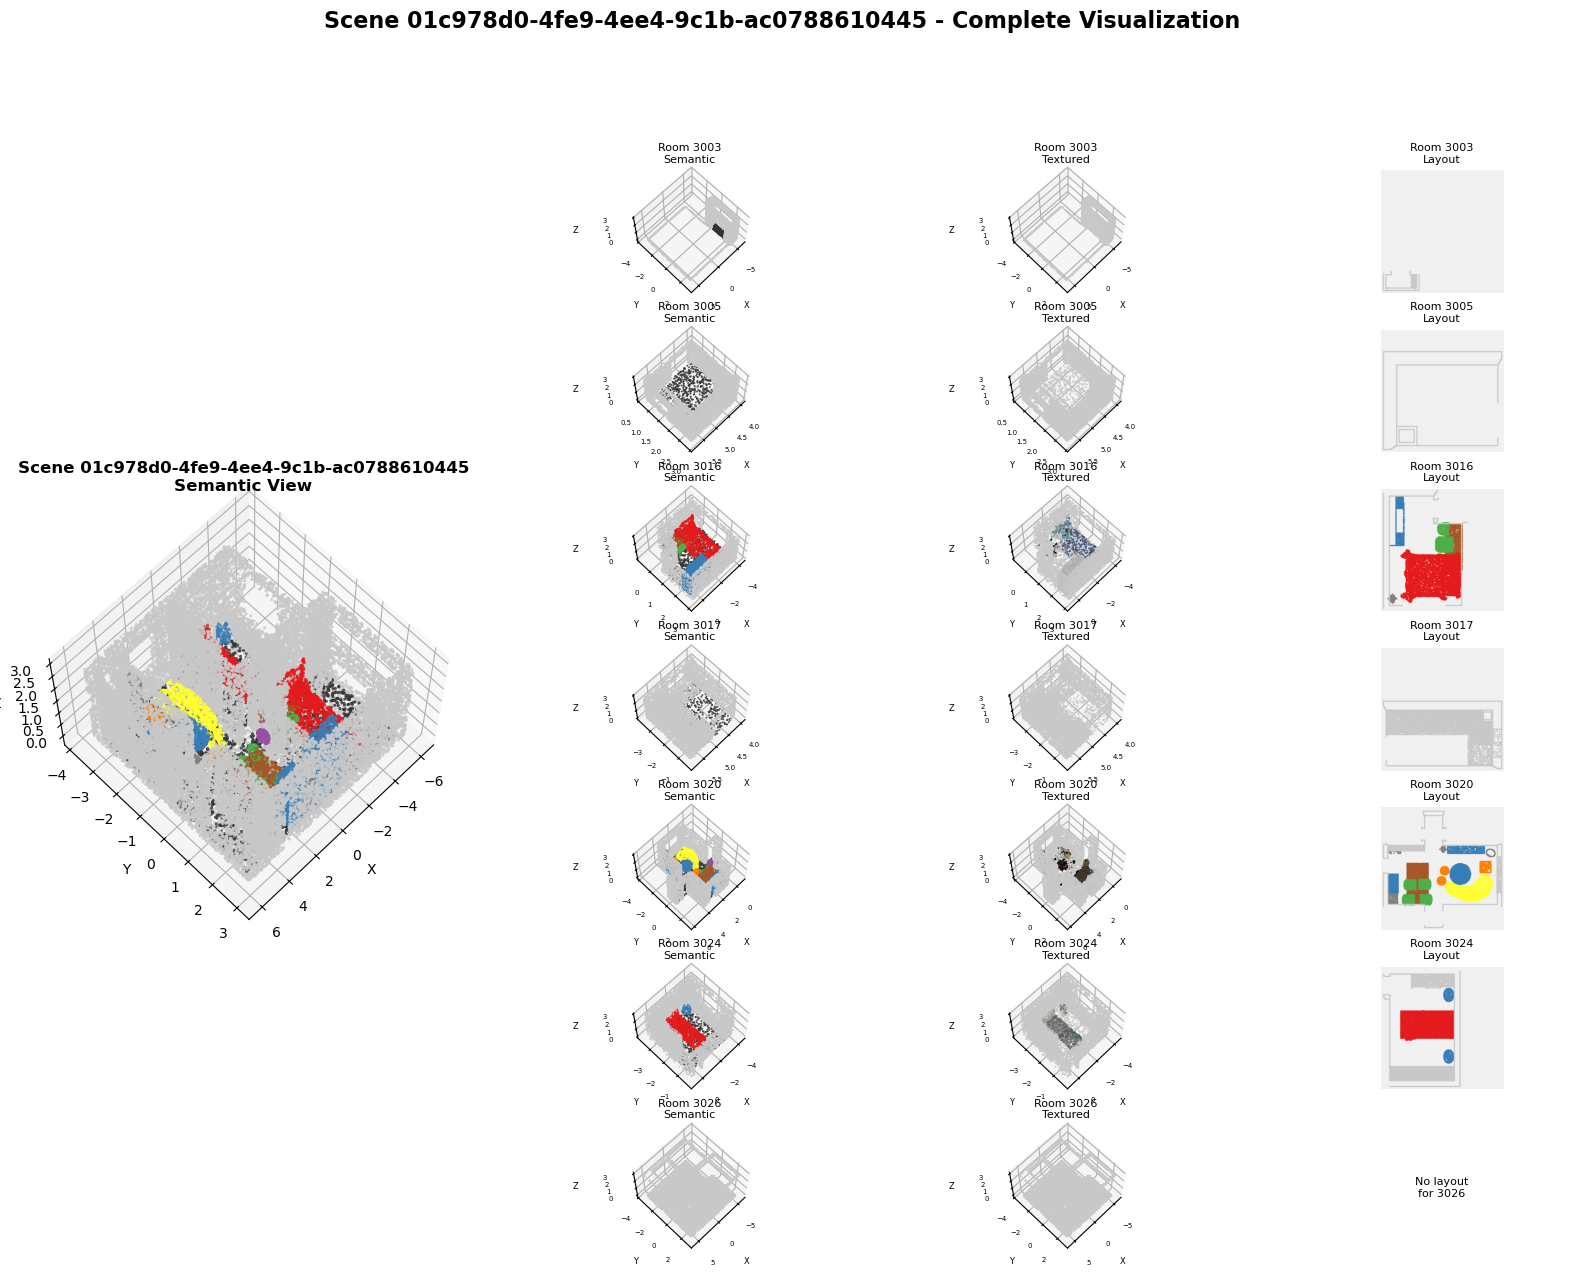

In [30]:
# After loading your existing code and taxonomy
fig = visualize_scene_with_rooms(
    scene_dir=Path(r"C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\repositories\ImagiNav\dataset\01c978d0-4fe9-4ee4-9c1b-ac0788610445"),
    scene_id="01c978d0-4fe9-4ee4-9c1b-ac0788610445",
    taxonomy=taxonomy,
    elev=65,  # Higher angle for bird's eye view (try 50-80)
    azim=45,  # Adjust rotation as needed
    point_size_scene=5.0,
    point_size_room=2
)
plt.show()


